###### Import Libraries

In [32]:
import pandas as pd

import numpy as np
from numpy import log

import collections
from collections import Counter #keeps track of how many times equivalent values are added

import missingno as msno

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px

import seaborn as sns
sns.set() #It gives your charts a seaborn background by default

import statsmodels.api as sm

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

import ppscore as pps #Predictive Power Score 

from scipy.signal import periodogram


from random import randrange
from pandas import Series
from statsmodels.tsa.seasonal import seasonal_decompose


from pandas.tseries.offsets import DateOffset
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.arima.model import ARIMA

from pandas import datetime
from pandas import read_csv
from pandas import DataFrame

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.tools.eval_measures import rmse 

import fbprophet
from fbprophet import Prophet

from statsmodels.tsa.stattools import kpss

from pylab import rcParams

from datetime import datetime, timedelta

from statsmodels.tsa.statespace.sarimax import SARIMAX 

#### Load Data

In [3]:
# Read csv files

#Plant 1 Cleansed DataFrame
Plant1 = pd.read_csv('Plant1_EDA.csv')

#Plant 2 Cleansed DataFrame
Plant2 = pd.read_csv('Plant1_EDA.csv')


# Preview the first 5 lines of the loaded data 
for df in [Plant1, Plant2]:
    print(df.info(), "\n")
    print("_"*80, "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68774 entries, 0 to 68773
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              68774 non-null  int64  
 1   DATE_TIME               68774 non-null  object 
 2   IRRADIATION             68774 non-null  float64
 3   AMBIENT_TEMPERATURE_F   68774 non-null  float64
 4   MODULE_TEMPERATURE_F    68774 non-null  float64
 5   PLANT_ID                68774 non-null  float64
 6   INVERTER_KEY            68774 non-null  object 
 7   DC_POWER                68774 non-null  float64
 8   AC_POWER                68774 non-null  float64
 9   CUMULATIVE_DAILY_YIELD  68774 non-null  float64
 10  TOTAL_YIELD             68774 non-null  float64
 11  DATE                    68774 non-null  object 
 12  TIME                    68774 non-null  object 
 13  HOUR                    68774 non-null  int64  
 14  MONTH                   68774 non-null

In [4]:
#drop Unnamed: 0 column

Plant1 = Plant1.drop(columns=['Unnamed: 0'])
Plant2 = Plant2.drop(columns=['Unnamed: 0'])


In [5]:
#Validate drop

for df in [Plant1, Plant2]:
    print(df.info(), "\n")
    print("*"*80, "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68774 entries, 0 to 68773
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DATE_TIME               68774 non-null  object 
 1   IRRADIATION             68774 non-null  float64
 2   AMBIENT_TEMPERATURE_F   68774 non-null  float64
 3   MODULE_TEMPERATURE_F    68774 non-null  float64
 4   PLANT_ID                68774 non-null  float64
 5   INVERTER_KEY            68774 non-null  object 
 6   DC_POWER                68774 non-null  float64
 7   AC_POWER                68774 non-null  float64
 8   CUMULATIVE_DAILY_YIELD  68774 non-null  float64
 9   TOTAL_YIELD             68774 non-null  float64
 10  DATE                    68774 non-null  object 
 11  TIME                    68774 non-null  object 
 12  HOUR                    68774 non-null  int64  
 13  MONTH                   68774 non-null  int64  
 14  YEAR                    68774 non-null

In [6]:
print(min(Plant1['DATE_TIME']))
print(max(Plant1['DATE_TIME']))

2020-05-15 00:00:00
2020-06-17 23:45:00


### Predict power generation for 2 days

Goal: predict the next two days of yield generated by Plant 1. I will use CUMULATIVE_DAILY_YIELD for power prediction.

I will use a SEASONAL ARIMA model to see if our model can capture the last generation trend.


In [7]:
Power_Pred = Plant1.copy()

In [8]:
# convert the datetime column to a datetime type and assign it back to the column
Power_Pred['DATE_TIME'] = pd.to_datetime(Power_Pred['DATE_TIME'])

In [9]:
Power_Pred.set_index('CUMULATIVE_DAILY_YIELD', inplace=True) 

In [10]:
Power_Pred = Plant1.copy()
Power_Pred = Power_Pred.groupby('DATE_TIME').sum()
Power_Pred = Power_Pred['CUMULATIVE_DAILY_YIELD'][-288:].reset_index() #4x 15 min slots per hour. -288 = -3 days
Power_Pred.set_index('DATE_TIME',inplace=True)
Power_Pred.tail()

,CUMULATIVE_DAILY_YIELD
DATE_TIME,
2020-06-17 22:45:00,129571.000000
2020-06-17 23:00:00,129571.000000
2020-06-17 23:15:00,129571.000000
2020-06-17 23:30:00,129571.000000
2020-06-17 23:45:00,127962.767857


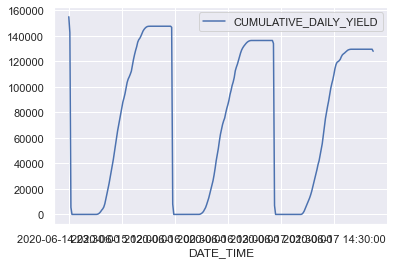

In [11]:
Power_Pred.plot()
plt.show()

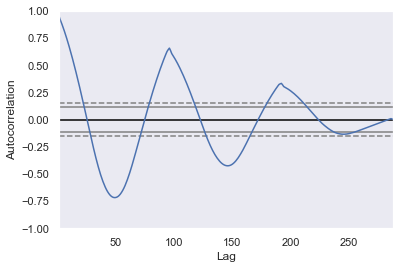

In [12]:
autocorrelation_plot(Power_Pred)
plt.show()

There is a positive correlation for the first 25 lags.

We will fit an ARIMA model to the entire dataset and review the residual errors.

                                 SARIMAX Results                                  
Dep. Variable:     CUMULATIVE_DAILY_YIELD   No. Observations:                  288
Model:                    ARIMA(25, 1, 0)   Log Likelihood               -3135.553
Date:                    Wed, 10 Feb 2021   AIC                           6323.105
Time:                            23:16:26   BIC                           6418.252
Sample:                                 0   HQIC                          6361.239
                                    - 288                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0863      0.078      1.112      0.266      -0.066       0.238
ar.L2         -0.2638      0.017    -15.088      0.000      -0.298      -0.230
ar.L3          0.038

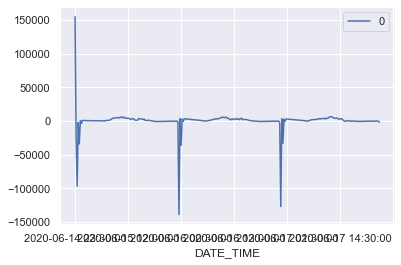

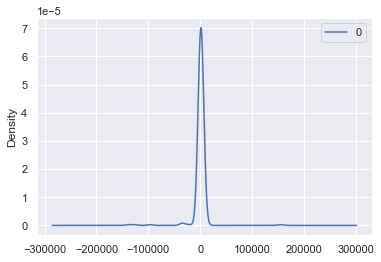

                   0
count     288.000000
mean      424.586539
std     16103.772579
min   -138613.954676
25%       -44.360858
50%      1053.248769
75%      3030.740973
max    155054.000000


In [13]:
# fit model
model = ARIMA(Power_Pred, order=(25,1,0)) #This sets the lag value to 25 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

predicted=-2462.608676, expected=0.000000
predicted=671.524719, expected=0.000000
predicted=1817.680194, expected=0.000000
predicted=1806.713784, expected=0.000000
predicted=1784.358175, expected=0.000000
predicted=1768.464384, expected=0.000000
predicted=1752.172143, expected=0.000000
predicted=1736.141273, expected=0.000000
predicted=1721.022154, expected=0.000000
predicted=39.949138, expected=0.000000
predicted=28.112304, expected=0.000000
predicted=19.780985, expected=0.000000
predicted=1666.280661, expected=0.000000
predicted=-0.054233, expected=0.000000
predicted=6.893901, expected=0.000000
predicted=4.857462, expected=0.000000
predicted=3.419980, expected=0.000000
predicted=2.406341, expected=0.000000
predicted=1.682246, expected=0.500000
predicted=1.659430, expected=362.660714
predicted=343.231093, expected=1248.982143
predicted=1185.753975, expected=2678.928571
predicted=2827.560052, expected=4647.196428
predicted=6065.443203, expected=6566.625000
predicted=6320.613781, expect

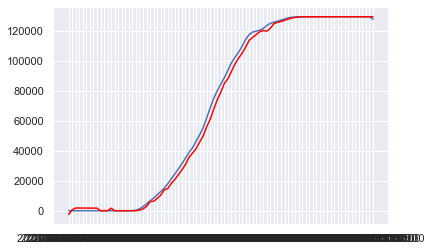

In [14]:
# split into train and test sets
X = Power_Pred.CUMULATIVE_DAILY_YIELD
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

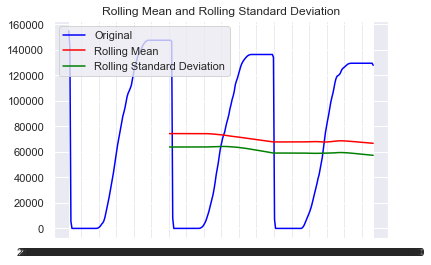

In [15]:
ROLLING_MEAN = Power_Pred.rolling(window = 96).mean()
ROLLING_STD = Power_Pred.rolling(window = 96).std()
plt.plot(Power_Pred, color = 'blue', label = 'Original')
plt.plot(ROLLING_MEAN, color = 'red', label = 'Rolling Mean')
plt.plot(ROLLING_STD, color = 'green', label = 'Rolling Standard Deviation')
plt.legend(loc = 'best')
plt.title('Rolling Mean and Rolling Standard Deviation')
plt.show()

Testing for Stationarity

A unit root test tests whether a time series variable is non-stationary and possesses a unit root. 

Augmented Dickey-Fuller test

In [94]:
ADF_RESULT = adfuller(Power_Pred['CUMULATIVE_DAILY_YIELD'])
print('ADF Statistic: %f' % ADF_RESULT[0])
print('p-value: %f' % ADF_RESULT[1])
print('Critical Values:')
for key, value in ADF_RESULT[4].items():
    print('\t%s: %.3f' % (key, value))
        
print(f'Result: The series {"does not have" if ADF_RESULT[1] <= 0.05 else "has"} a unit root, is {"non " if ADF_RESULT[1] <= 0.05 else ""}stationary, and has {"strong" if ADF_RESULT[1] <= 0.05 else "weak"} evidence against the null hypothesis. The null hypothesis {"should" if ADF_RESULT[1] <= 0.05 else "should not"} be rejected.')     




ADF Statistic: -1.739438
p-value: 0.410916
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
Result: The series has a unit root, is stationary, and has weak evidence against the null hypothesis. The null hypothesis should not be rejected.


In [16]:
#check against KPSS test for for Stationarity

#A unit root test tests whether a time series variable is non-stationary and possesses a unit root. 

#define KPSS
def kpss_test(Power_Pred, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(Power_Pred, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(Power_Pred)

KPSS Statistic: 0.15003755109783629
p-value: 0.1
num lags: 16
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


##### Split into train and test datasets to build the model on the training dataset and forecast using the test dataset.

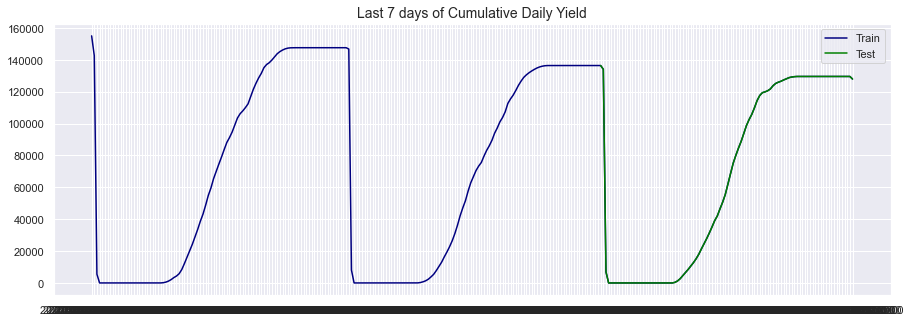

In [17]:
train=Power_Pred[:288]
test=Power_Pred[-96:]
plt.figure(figsize=(15,5))
plt.plot(train,label='Train',color='navy')
plt.plot(test,label='Test',color='green')
plt.title('Last 7 days of Cumulative Daily Yield',fontsize=14)
plt.legend()
plt.show()

#### Tune with Auto ARIMA

The auto_arima function fits the best ARIMA model to an univariate time with stepwise search over possible model & seasonal orders within the constraints provided, and selects the parameters that minimize the given metric.

Since observations are recorded at 15 minute intervals the m parameter is set to 96 to capture daily trends.

In [18]:
#Parameter Analysis for ARIMA model

arima_model = auto_arima(train,
                         start_p=0,d=1,start_q=0,
                         max_p=4,max_d=4,max_q=4,
                         start_P=0,D=1,start_Q=0,
                         max_P=1,max_D=1,max_Q=1,m=96, #96 observations for 1 day
                         seasonal=True,
                         error_action='warn',trace=True,
                         supress_warning=True,stepwise=True,
                         random_state=20,n_fits=1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[96]             : AIC=3332.042, Time=1.28 sec
 ARIMA(1,1,0)(1,1,0)[96]             : AIC=3281.970, Time=3.86 sec
 ARIMA(0,1,1)(0,1,1)[96]             : AIC=3281.224, Time=11.04 sec
 ARIMA(0,1,1)(0,1,0)[96]             : AIC=3284.717, Time=0.84 sec
 ARIMA(0,1,1)(1,1,1)[96]             : AIC=inf, Time=27.25 sec
 ARIMA(0,1,1)(1,1,0)[96]             : AIC=3286.655, Time=5.16 sec
 ARIMA(0,1,0)(0,1,1)[96]             : AIC=3333.974, Time=4.21 sec
 ARIMA(1,1,1)(0,1,1)[96]             : AIC=3286.742, Time=10.39 sec
 ARIMA(0,1,2)(0,1,1)[96]             : AIC=3282.107, Time=6.07 sec
 ARIMA(1,1,0)(0,1,1)[96]             : AIC=3281.941, Time=4.08 sec
 ARIMA(1,1,2)(0,1,1)[96]             : AIC=3279.419, Time=15.25 sec
 ARIMA(1,1,2)(0,1,0)[96]             : AIC=3280.070, Time=2.95 sec
 ARIMA(1,1,2)(1,1,1)[96]             : AIC=inf, Time=27.49 sec
 ARIMA(1,1,2)(1,1,0)[96]             : AIC=3280.079, Time=16.36 sec
 ARIMA(2,1,2)(0,1,1)[96

In [19]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  288
Model:             SARIMAX(0, 1, 3)x(0, 1, [], 96)   Log Likelihood               -1634.455
Date:                             Wed, 10 Feb 2021   AIC                           3276.910
Time:                                     23:22:00   BIC                           3289.919
Sample:                                          0   HQIC                          3282.179
                                             - 288                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1357      0.011    -11.807      0.000      -0.158      -0.113
ma.L2          0.0280      0.029      0.974      0.330      -0.028       0.084
ma.L3          0.0407      0.041      0.983      0.326      -0.040       0.122
sigma2      1.408e+06   3.06e+04     46.001      0.000    1.35e+06    1.47e+06
===================================================================================
Ljung-Box (L1) (Q):                  30.33   Jarque-Bera (JB):             10191.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.59   Skew:                             4.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

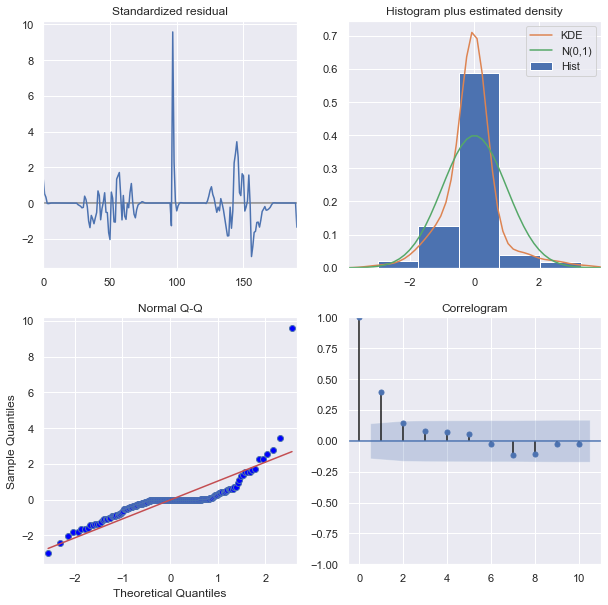

In [20]:
arima_model.plot_diagnostics(figsize=(10,10))
plt.show()

Residual errors seem to fluctuate drastically at three specific points, 50, 100, and 150. 

The Density plot suggest slightly skewed distribution with mean mostly around zero. 

There are a few slight deviations that would imply the distribution is slightly skewed.

The Correlogram shows a low positive correlations that slowly declines with increasing lags. Residual errors are not autocorrelated and more predictors will need to be consdiered for the model.

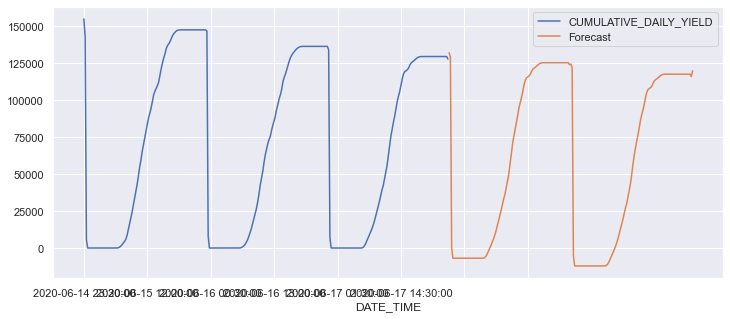

In [21]:
# Train the model on the full dataset 
model = model = SARIMAX(Power_Pred['CUMULATIVE_DAILY_YIELD'],  
                        order = (1, 1, 1),  
                        seasonal_order =(1, 1, 1, 96)) 
result = model.fit() 
  
# Forecast for the next 3 days
forecast = result.predict(start = len(Power_Pred),  
                          end = (len(Power_Pred)-96) + 3 * 96,  
                          typ = 'levels').rename('Forecast') 
  
# Plot the forecast values 
Power_Pred['CUMULATIVE_DAILY_YIELD'].plot(figsize = (12, 5), legend = True) 
forecast.plot(legend = True)
plt.show()

In [22]:
start = len(train) 
end = len(train) + len(test) - 1

Fit ARIMA Model to Plant1 dataset

In [23]:
Forecast_dates = [test.index[-1] + str(DateOffset(minutes=x)) for x in range(0,2880,15) ] # range(start,stop,step)

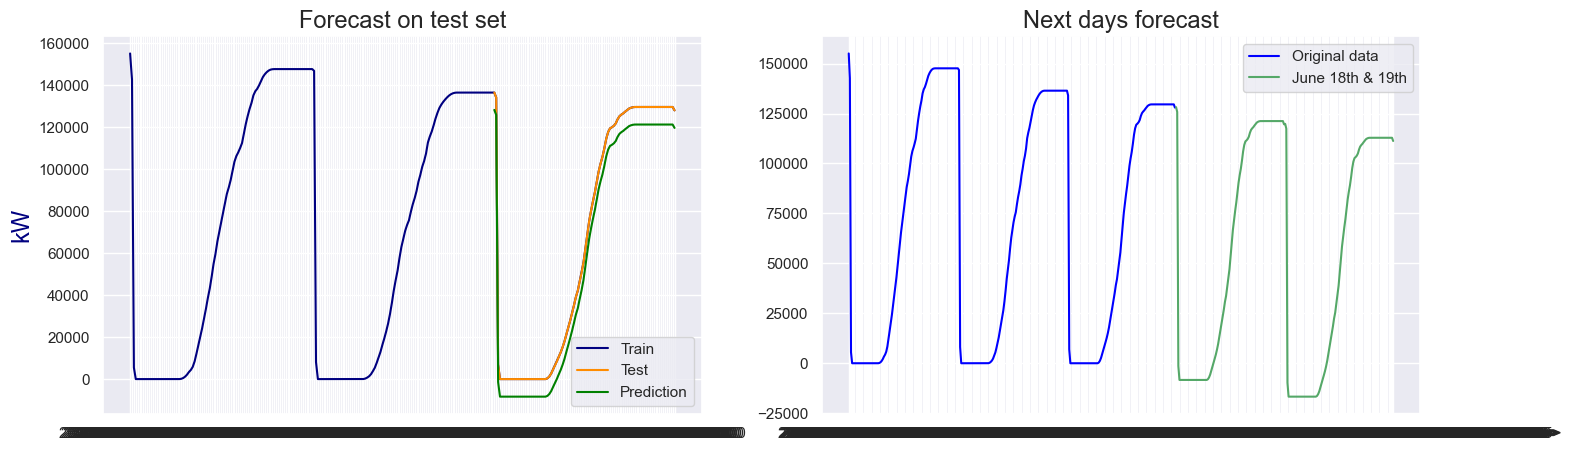

In [30]:
# Predictions for two day against test set 
prediction=pd.DataFrame(arima_model.predict(n_periods=96),index=test.index)
prediction.columns=['PREDICTED_CUMULATIVE_DAILY_YIELD']                          


fig,ax= plt.subplots(ncols=2,nrows=1,dpi=100,figsize=(17,5))
ax[0].plot(train,label='Train',color='navy')
ax[0].plot(test,label='Test',color='darkorange')
ax[0].plot(prediction,label='Prediction',color='green')
ax[0].legend()
ax[0].set_title('Forecast on test set',size=17)
ax[0].set_ylabel('kW',color='navy',fontsize=17)


f_prediction=pd.DataFrame(arima_model.predict(n_periods=192),index=Forecast_dates)
f_prediction.columns=['PREDICTED_CUMULATIVE_DAILY_YIELD']
ax[1].plot(Power_Pred,label='Original data',color='blue')
ax[1].plot(f_prediction,label='June 18th & 19th',color='g')
ax[1].legend()
ax[1].set_title('Next days forecast',size=17)
plt.show()

In [34]:
print(arima_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  288
Model:             SARIMAX(0, 1, 3)x(0, 1, [], 96)   Log Likelihood               -1634.455
Date:                             Wed, 10 Feb 2021   AIC                           3276.910
Time:                                     23:39:01   BIC                           3289.919
Sample:                                          0   HQIC                          3282.179
                                             - 288                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1357      0.011    -11.807      0.000      -0.158      -0.113
ma.L2          0.0280      

In [36]:
print('SARIMAX R2 Score: %f' % (r2_score(prediction['PREDICTED_CUMULATIVE_DAILY_YIELD'],test['CUMULATIVE_DAILY_YIELD'])))
print('-'*15)
print('SARIMAX MAE Score: %f' % (mean_absolute_error(prediction['PREDICTED_CUMULATIVE_DAILY_YIELD'],test['CUMULATIVE_DAILY_YIELD'])))
print('-'*15)
print('SARIMAX RMSE Score: %f' % (mean_squared_error(prediction['PREDICTED_CUMULATIVE_DAILY_YIELD'],test['CUMULATIVE_DAILY_YIELD'],squared=False)))

SARIMAX R2 Score: 0.978532
---------------
SARIMAX MAE Score: 8356.832818
---------------
SARIMAX RMSE Score: 8356.842920


Observations:

During EDA we identified faulty or potentially suboptimal inverters. 

Through Modeling we were able to forecast univariate time series to predict Power generation for the next two days for Plant 1. We used CUMULATIVE_DAILY_YIELD for power prediction.


We will continue modeling to see if relative size of error decreases since our goal is to decrease the error with each iteration. 